.# Labelling Famous Landmarks (Analysis of Results)

In this notebook it is going to be presented the analysis of the results after performing the experiments with neural networks in previous steps of my data science project about the **Google Landmark Recognition 2020** dataset. The objective is to select the best models according to their performance and also evaluate them on the test set. 

# Index of Contents


1.   Loading modules and data
2.   VGG architecture
3.   Xception architecture
4.   Other annotations
5.   Ranking
6.   Evaluation
7.   Conclusions



# Load modules and data

As always the first thing to do is loading the libraries and data to work with. For now, the registry with the results are enough, later on the evaluation part the corresponding test sets will be loaded.

In [9]:
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import image_dataset_from_directory
from keras.optimizers import Adam, RMSprop
from keras.losses import CategoricalCrossentropy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import random

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The GPU is necessary again because with the CPU is not enough for evaluating, although the test set is small percent it still has a great number of images.

In [11]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
seed = 487

In [13]:
VGG_feature_extraction = pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_feature_extraction.csv")
VGG_fine_tuning =pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_VGG16_fine_tuning.csv")
Xception_feature_extraction = pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_Xception_feature_extraction.csv")
Xception_fine_tuning =pd.read_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/log_Xception_fine_tuning.csv")

Once the registries are loaded, let's check their size and see some samples of their inner structure.

In [14]:
print(VGG_feature_extraction.shape)
VGG_feature_extraction.sample(3, random_state=seed)

(20, 22)


,batch,classes,data_augmentation,dense,epochs,flatten,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,global_average,dense_1,dropout,dense_2,dropout_1
15,256.0,20.0,False,20.0,20.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.939,0.969,0.151,0.662,0.814,0.621,NaN,512.0,0.5,512.0,0.5
14,256.0,20.0,False,20.0,20.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.993,0.997,0.029,0.691,0.832,0.613,NaN,512.0,0.5,NaN,NaN
5,512.0,200.0,False,200.0,20.0,1.0,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.998,0.999,0.042,0.386,0.614,1.900,NaN,NaN,NaN,NaN,NaN


In [15]:
print(VGG_fine_tuning.shape)
VGG_fine_tuning.sample(3, random_state=seed)

(17, 20)


,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout
9,20,128,512,False,0.000001,RMSprop,50,15,20,True,0.001,1.000,1.000,0.580,0.880,0.774,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN
12,20,128,512,False,0.000001,RMSprop,50,15,20,True,0.000,1.000,1.000,0.523,0.904,0.817,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5
5,200,128,256,False,0.000010,RMSprop,50,16,200,True,0.703,0.862,0.744,1.573,0.632,0.415,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5


In [16]:
print(Xception_feature_extraction.shape)
Xception_feature_extraction.sample(3, random_state=seed)

(18, 20)


,batch,classes,data_augmentation,dense,dropout,epochs,global_average,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,flatten,dense_1
10,256.0,20.0,False,20.0,NaN,20.0,NaN,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.832,0.912,0.349,0.638,0.798,0.673,0.0,NaN
12,256.0,20.0,False,20.0,0.5,20.0,NaN,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.993,0.997,0.024,0.696,0.835,0.691,1.0,512.0
9,256.0,20.0,False,20.0,NaN,20.0,NaN,128.0,0.0010,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.998,0.999,0.029,0.687,0.828,0.742,1.0,NaN


In [17]:
print(Xception_fine_tuning.shape)
Xception_fine_tuning.sample(3, random_state=seed)

(18, 21)


,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout,dropout_1
10,20,128,256,True,0.00001,RMSprop,40,128,20,True,0.529,0.834,0.698,0.681,0.788,0.616,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN,NaN
12,20,128,256,True,0.00001,RMSprop,40,126,20,True,0.518,0.837,0.703,0.648,0.803,0.638,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,NaN,0.5
9,20,128,256,True,0.00001,RMSprop,40,128,20,True,0.424,0.866,0.753,0.599,0.818,0.659,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5,NaN


Their structure is very similar if we take a look on the basic hyperparameters, however they differ in the architectural layers. Some of them have more columns and that means there are some experiments with larger structures on the classification block. 

## Tensorboard

Before going on further details with the explanation of the results, I want to upload all the training logs made by the hyperparameters checkpoints on Tensorboard. It will generate a dashboard with all the training, validation and loss curves for all experiments and everybody can consult them on clicking on the [link](https://tensorboard.dev/experiment/5gfr6pkJRDS6cPD6X8R99Q/). 

**Note** -- For security purposes of my personal account I can't let the execution of the cell code, so it is commented just in case you need to do something similar.

In [18]:
%load_ext tensorboard

In [ ]:
# !tensorboard dev upload --logdir "/content/drive/MyDrive/4º de Carrera/TFG/TensorBoard_Logs" \
#   --name "TensorBoard Logs" \
#   --description "Results from all experiments" \
#   --one_shot

# VGG architecture

For readability purpose, the analysis is going to be performed based on the two types of architectures that have been used during the experiments. Also, for each architecture, two kind of transfer learning tecniques were applied, so the idea is to compare performance and variances with the aim to later on select the best one.

## VGG feature extraction

In [19]:
print("Experiments with 20 classes: ", len(VGG_feature_extraction[VGG_feature_extraction['classes']== 20]))
print("Experiments with 200 classes: ", len(VGG_feature_extraction[VGG_feature_extraction['classes']== 200]))

Experiments with 20 classes:  9
Experiments with 200 classes:  11


There is no big difference in the number of experiments carried out for each stage. Just as a reminder, the approach for the project was to divide the process of model building in two stages: the first with 200 classes and then scale down to see what happens with less classes (20).

In [20]:
def plot_violin(df):
  fig, axes = plt.subplots(1, 4,figsize = (25,5))
 
  sns.violinplot(ax=axes[0], x="classes", y="val_acc",  data=df, palette="RdBu", inner="point",height=5, aspect=1)
  axes[0].set_title("Val accuracy")

  sns.violinplot(ax=axes[1], x="classes", y="val_GAP",  data=df, palette="PuOr", inner="point", height=5, aspect=1)
  axes[1].set_title("Val GAP")

  sns.violinplot(ax=axes[2], x="classes", y="train_acc",  data=df, palette="Set3",  inner="point", height=5, aspect=1)
  axes[2].set_title("Train accuracy")

  sns.violinplot(ax=axes[3], x="classes", y="train_GAP",  data=df, palette="Set2", inner="point", height=5, aspect=1)
  axes[3].set_title("Train GAP")
  plt.show()

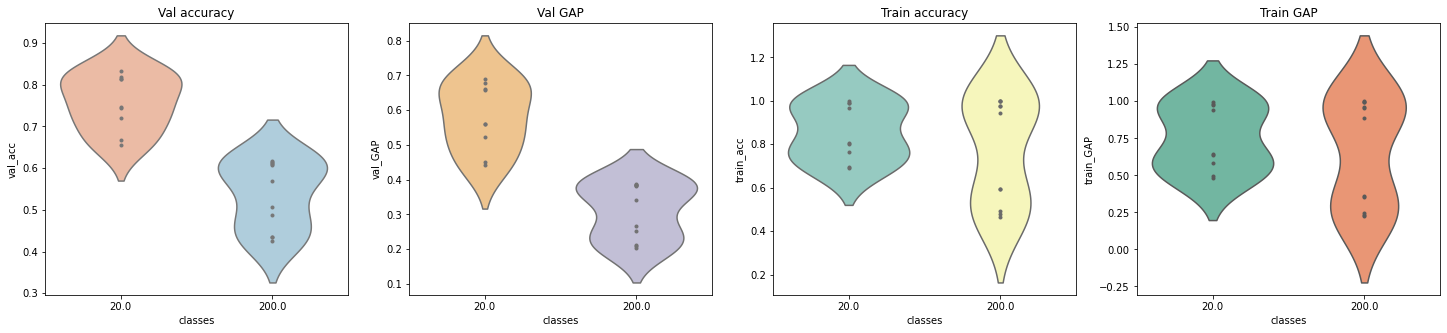

In [21]:
plot_violin(VGG_feature_extraction)

Violin graphs representation has been chosen to be the primary way of analysing the distribution of the neural network outcomes. It is more intuitive to understand what had happened. At first sight there are different things that can be noticed:

*   The validation accuracy and GAP is lower on model trained with 200 classes. 
*   Both metrics usually have the same score, but accuracy is always a little bit higher and with less variance than GAP.
*   The train metrics seems to be above compared to the results of the validation set.


One of the things that I have noticed was that **data augmentation** has a great impact on the results. There was a huge gap between training and validation scores without applying data augmentation, but there were no overfitting because validation accuracy was always increasing. However, when the data augmentation block was added to the models, that gap was reduced and both curves grew with the same rythm, but scores were lower as a side effect. So, at the end the effect was not the expected one.

In [22]:
params_feature_extraction = ["classes","data_augmentation","optimizer", "learning_rate", "epochs","train_acc", "train_GAP", "val_acc","val_GAP"]

In [23]:
df = VGG_feature_extraction[VGG_feature_extraction['classes']==200][params_feature_extraction].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
6,200.0,False,Adam,0.0001,25.0,1.000,0.999,0.616,0.388
5,200.0,False,Adam,0.0010,20.0,0.999,0.998,0.614,0.386
4,200.0,False,Adam,0.0010,15.0,0.978,0.957,0.611,0.381
0,200.0,False,Adam,0.0010,15.0,0.998,0.997,0.609,0.386
3,200.0,False,Adam,0.0010,15.0,0.978,0.959,0.607,0.386
2,200.0,False,Adam,0.0010,15.0,0.943,0.889,0.569,0.341
10,200.0,True,Adam,0.0010,20.0,0.594,0.356,0.507,0.267
7,200.0,True,Adam,0.0010,15.0,0.596,0.361,0.488,0.253
8,200.0,True,Adam,0.0010,15.0,0.491,0.245,0.435,0.210
1,200.0,False,Adam,0.0010,15.0,0.477,0.234,0.434,0.213


One thing that I forgot to remarked at the beginning is the way the hyperparameters were chosen. For instance, for **feature extraction** the optimezer was set to *Adam*, meanwhile for **fine_tuning** it was chosen *RMSProp*. Moreover, the range of values for  **learning rates** and **epochs** is based on this criteria too.

In [38]:
def plot_lines(df1, df2):
    fig, axes = plt.subplots(1, 2,figsize = (15,5))
    
    sns.lineplot(ax=axes[0], data=df1[["train_acc", "train_GAP","val_acc","val_GAP"]], markers=True, palette="Set1")
    axes[0].set_title("Scores without data augmentation")
    axes[0].set(xlabel='Model ID', ylabel='Score')

    sns.lineplot(ax=axes[1], data=df2[["train_acc", "train_GAP","val_acc","val_GAP"]], markers=True, palette="Set1")
    axes[1].set_title("Scores with data augmentation")
    axes[1].set(xlabel='Model ID', ylabel='Score')

    plt.show()

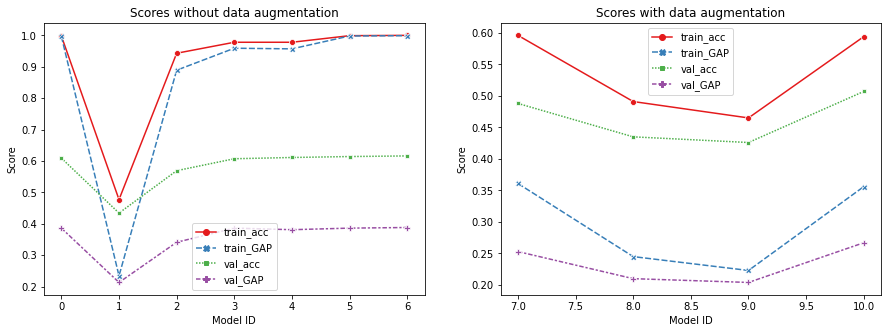

In [40]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

In [41]:
df = VGG_feature_extraction[VGG_feature_extraction['classes']==20][params_feature_extraction].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
14,20.0,False,Adam,0.0001,20.0,0.997,0.993,0.832,0.691
13,20.0,False,Adam,0.0010,20.0,0.990,0.979,0.819,0.677
15,20.0,False,Adam,0.0001,20.0,0.969,0.939,0.814,0.662
11,20.0,False,Adam,0.0010,20.0,0.989,0.978,0.813,0.659
19,20.0,True,Adam,0.0010,20.0,0.801,0.640,0.746,0.560
18,20.0,True,Adam,0.0010,20.0,0.804,0.647,0.745,0.560
16,20.0,True,Adam,0.0001,20.0,0.763,0.585,0.720,0.523
17,20.0,True,Adam,0.0001,20.0,0.696,0.496,0.668,0.452
12,20.0,False,Adam,0.0010,20.0,0.689,0.481,0.656,0.441


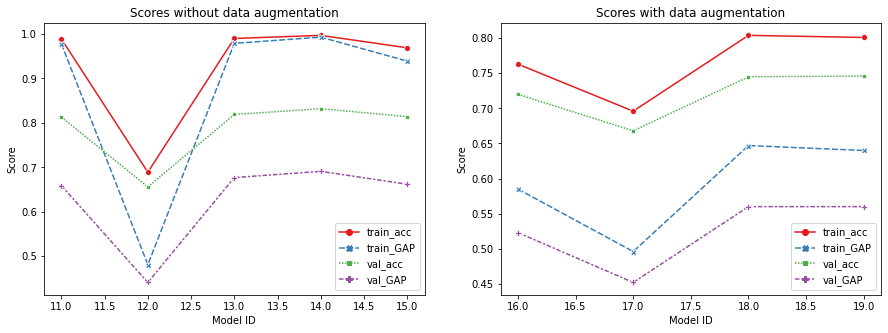

In [42]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

Looking to the "paired values" of both metrics for train and validation, it is clear the mentioned gap between scores. Also, the results for the model with 200 classes are not very good  because most of them are near `0.5` and the rest are not much better than a trivial classifier. On the other hand, models with 20 classes seems to be significantly more accurate. This effect can be related to the fact that the less classes, the less variance there is. We also know from the EDA that as the number of classes increases, there are fewer images per class and each one is unique. So, it is reasonable to think that models with more classes have struggled learning patterns to classify. Moreover,because of this intra-class variance, models with 20 classes have not achieved even higher scores too.

In [43]:
pd.options.mode.chained_assignment = None  #Just a setting for not showing warning in pandas module

In [44]:
# Get only the best model with 200 classes based on accuracy
db1 = VGG_feature_extraction[VGG_feature_extraction['classes']==200]
VGG_fe_best_model_200 = db1[db1['val_acc']==db1['val_acc'].max()]
VGG_fe_best_model_200["kind"] = "VGG_feature_extraction"
VGG_fe_best_model_200

,batch,classes,data_augmentation,dense,epochs,flatten,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,global_average,dense_1,dropout,dense_2,dropout_1,kind
6,512.0,200.0,False,200.0,25.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.999,1.0,0.035,0.388,0.616,1.902,NaN,NaN,NaN,NaN,NaN,VGG_feature_extraction


In [45]:
# Get only the best model with 20 classes based on accuracy
db2 = VGG_feature_extraction[VGG_feature_extraction['classes']==20]
VGG_fe_best_model_20 = db2[db2['val_acc']==db2['val_acc'].max()]
VGG_fe_best_model_20["kind"] = "VGG_feature_extraction"
VGG_fe_best_model_20

,batch,classes,data_augmentation,dense,epochs,flatten,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,global_average,dense_1,dropout,dense_2,dropout_1,kind
14,256.0,20.0,False,20.0,20.0,1.0,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.993,0.997,0.029,0.691,0.832,0.613,NaN,512.0,0.5,NaN,NaN,VGG_feature_extraction


## VGG fine tuning

In [46]:
print("Experiments with 20 classes: ", len(VGG_fine_tuning[VGG_fine_tuning['classes']== 20]))
print("Experiments with 200 classes: ", len(VGG_fine_tuning[VGG_fine_tuning['classes']== 200]))

Experiments with 20 classes:  9
Experiments with 200 classes:  8


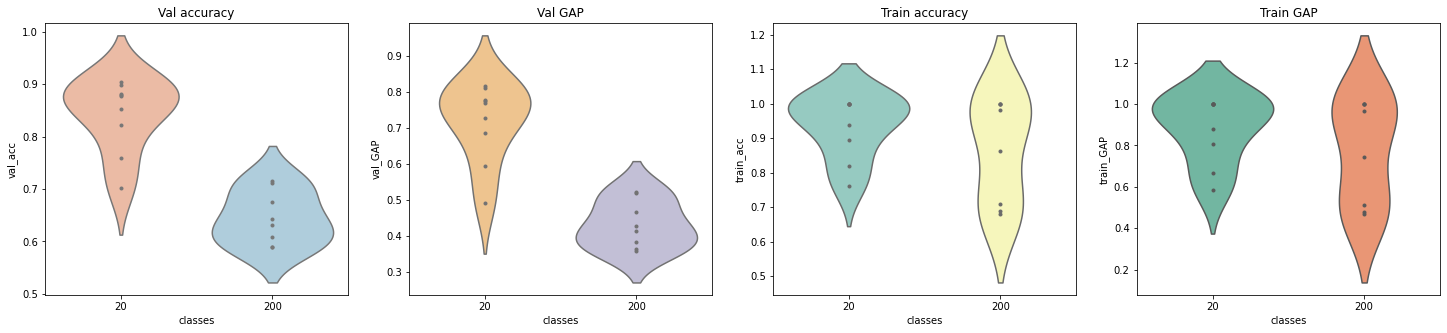

In [47]:
plot_violin(VGG_fine_tuning)

The difference with the previous transfer learning tecnique is slight, but relevant. 

*   Both validation scores are higher, what is a great improvement.
*   Apparently the difference between metrics is undistinguished.



In [48]:
params_fine_tuning = ["classes","data_augmentation", "freezed_layers", "optimizer","learning_rate","epochs","train_acc", "train_GAP", "val_acc","val_GAP"]

In [49]:
df = VGG_fine_tuning[VGG_fine_tuning['classes']==200][params_fine_tuning].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,freezed_layers,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
7,200,False,16,RMSprop,1.000000e-04,50,1.000,1.000,0.715,0.522
6,200,False,16,RMSprop,1.000000e-04,50,0.999,0.999,0.712,0.521
1,200,False,16,RMSprop,1.000000e-05,35,1.000,1.000,0.675,0.468
0,200,False,15,RMSprop,1.000000e-05,35,0.982,0.966,0.643,0.427
5,200,False,16,RMSprop,1.000000e-05,50,0.862,0.744,0.632,0.415
4,200,True,16,RMSprop,1.000000e-07,50,0.709,0.510,0.608,0.383
2,200,True,16,RMSprop,1.000000e-05,40,0.680,0.469,0.589,0.358
3,200,True,15,RMSprop,1.000000e-05,45,0.688,0.478,0.589,0.365


As was mentioned before, for fine tunig we have stablished *RMSProp* as default optimizer. Also the ranges for the **learning rate** and **epochs** have changed because these kind of fine tuning needs more epochs with very small learning rate values.Another thing to consider is the number of **freezed layers** with which the followed criteria was to let 2 to 8 unfrozen layers of the architectures. However, trying to many combinations was not possible due to time restrictions.

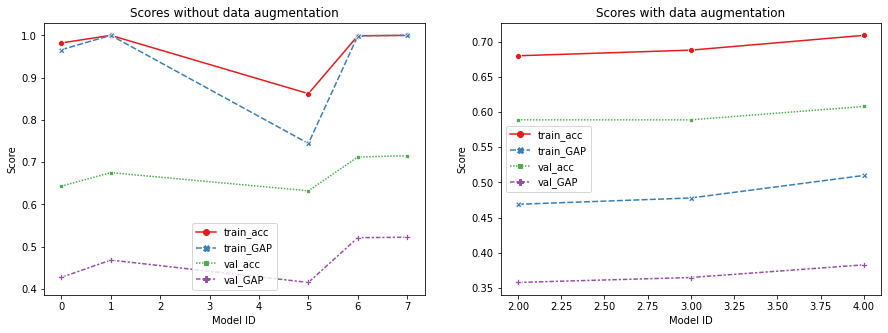

In [50]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

In [51]:
df = VGG_fine_tuning[VGG_fine_tuning['classes']==20][params_fine_tuning].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,freezed_layers,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
12,20,False,15,RMSprop,0.000001,50,1.000,1.000,0.904,0.817
11,20,False,15,RMSprop,0.000100,50,1.000,1.000,0.898,0.811
10,20,False,17,RMSprop,0.000100,50,1.000,1.000,0.881,0.777
9,20,False,15,RMSprop,0.000001,50,1.000,1.000,0.880,0.774
8,20,False,15,RMSprop,0.000100,50,1.000,1.000,0.877,0.769
16,20,True,17,RMSprop,0.000100,50,0.937,0.879,0.852,0.729
15,20,True,15,RMSprop,0.001000,50,0.896,0.806,0.823,0.686
13,20,True,15,RMSprop,0.000001,50,0.819,0.668,0.759,0.595
14,20,True,15,RMSprop,0.000001,50,0.762,0.583,0.702,0.492


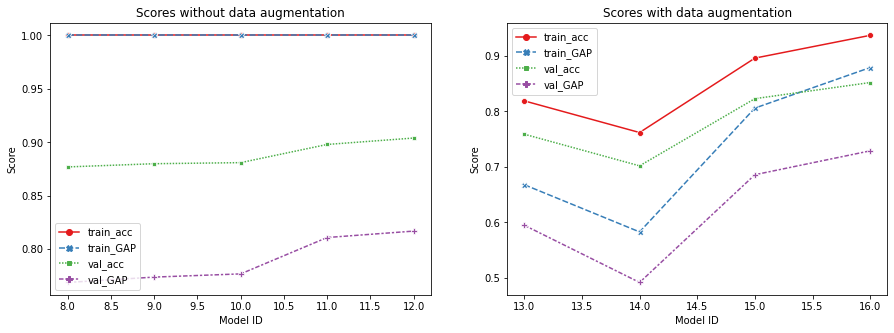

In [52]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

Again **data augmentation** has the same effect on the neural networks as before. However, the scores can be considered significantly better compared to the same architecture with feature extraction. Another factor to consider with fine tuning is an extra hyperparamenter: the number of **freezed layers**. This one has a great impact on the behaviour of the network and it is very dependant on the **learning rate**. On some of the models with 20 classes was noticed during training that there were a high risk of overfitting. Because of that, it is preferable very low learning rates to avoid this cases and let the network learn features better. On the other hand, fine tuning supposed a great improvement on the performance of the model with 200 classes. However, due to time and resource limits it was not possible to continue on experimenting other promising combinations.

In [53]:
# Get only the best model with 200 classes based on accuracy
db1 = VGG_fine_tuning[VGG_fine_tuning['classes']==200]
VGG_ft_best_model_200 = db1[db1['val_acc']==db1['val_acc'].max()]
VGG_ft_best_model_200["kind"] = "VGG_fine_tuning"
VGG_ft_best_model_200

,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout,kind
7,200,128,256,False,0.0001,RMSprop,50,16,200,True,0.001,1.0,1.0,1.883,0.715,0.522,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,NaN,NaN,VGG_fine_tuning


In [54]:
# Get only the best model with 20 classes based on accuracy
db2 = VGG_fine_tuning[VGG_fine_tuning['classes']==20]
VGG_ft_best_model_20 = db2[db2['val_acc']==db2['val_acc'].max()]
VGG_ft_best_model_20["kind"] = "VGG_fine_tuning"
VGG_ft_best_model_20

,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout,kind
12,20,128,512,False,0.000001,RMSprop,50,15,20,True,0.0,1.0,1.0,0.523,0.904,0.817,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5,VGG_fine_tuning


# Xception architecture

The same procedure as on the previous section will be done with the Xception architecture.

## Xception feature extraction

In [55]:
print("Experiments with 20 classes: ", len(Xception_feature_extraction[Xception_feature_extraction['classes']== 20]))
print("Experiments with 20 classes: ", len(Xception_feature_extraction[Xception_feature_extraction['classes']== 200]))

Experiments with 20 classes:  9
Experiments with 20 classes:  9


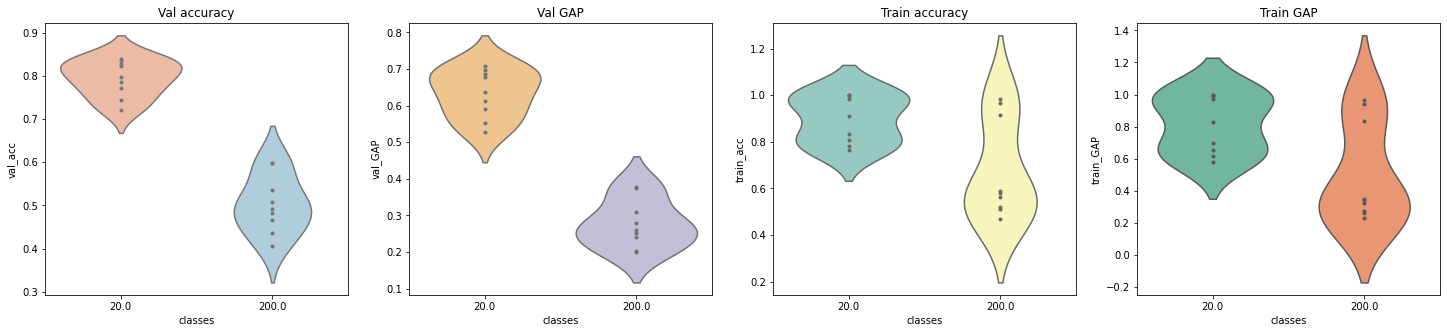

In [56]:
plot_violin(Xception_feature_extraction)

The distributions look very similar to the ones with the VGG architecture for  the feature extraction case.

*   Models with 200 classes has lower performance
*   There is an important gap between train and validation scores.

However, there are some little differences as for example:

*   The scores are higher compared to VGG
*   There is less variance on the validation accuracy



In [57]:
df = Xception_feature_extraction[Xception_feature_extraction['classes']==200][params_feature_extraction].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
2,200.0,False,Adam,0.0001,20.0,0.968,0.939,0.599,0.377
4,200.0,False,Adam,0.0001,20.0,0.983,0.966,0.599,0.376
3,200.0,False,Adam,0.0010,20.0,0.915,0.838,0.535,0.309
5,200.0,True,Adam,0.0001,20.0,0.587,0.351,0.509,0.278
1,200.0,False,Adam,0.0001,20.0,0.581,0.341,0.491,0.261
0,200.0,False,Adam,0.0001,20.0,0.565,0.325,0.483,0.253
6,200.0,True,Adam,0.0001,20.0,0.519,0.274,0.467,0.242
8,200.0,True,Adam,0.0010,20.0,0.510,0.263,0.435,0.201
7,200.0,True,Adam,0.0010,20.0,0.470,0.232,0.407,0.203


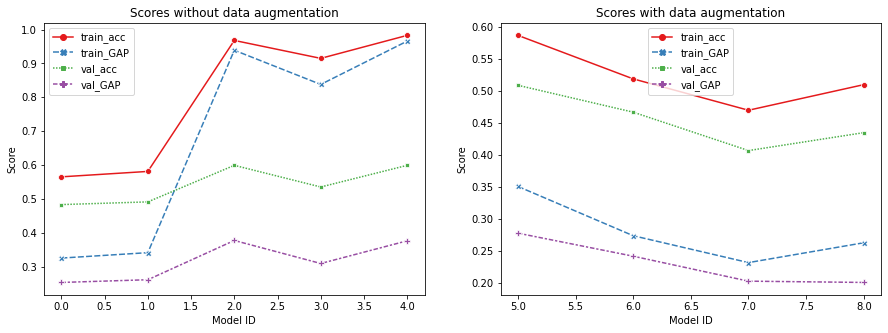

In [58]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

In [59]:
df = Xception_feature_extraction[Xception_feature_extraction['classes']==20][params_feature_extraction].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
13,20.0,False,Adam,0.0001,25.0,0.999,0.998,0.840,0.708
12,20.0,False,Adam,0.0001,20.0,0.997,0.993,0.835,0.696
9,20.0,False,Adam,0.0010,20.0,0.999,0.998,0.828,0.687
11,20.0,False,Adam,0.0010,20.0,0.985,0.972,0.823,0.677
10,20.0,False,Adam,0.0010,20.0,0.912,0.832,0.798,0.638
14,20.0,True,Adam,0.0001,25.0,0.832,0.695,0.786,0.613
15,20.0,True,Adam,0.0001,25.0,0.806,0.655,0.772,0.591
17,20.0,True,Adam,0.0010,25.0,0.783,0.616,0.744,0.553
16,20.0,True,Adam,0.0010,25.0,0.763,0.582,0.722,0.529


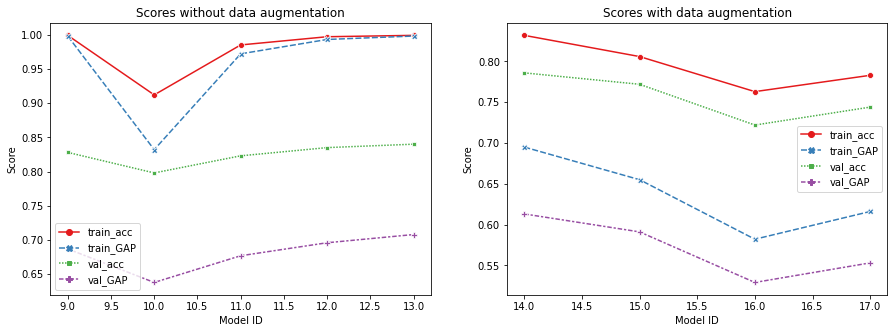

In [60]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

Nothing more to say that **data augmentation** has produced the same outcome on this architecture. It definetely reduce the train scores rather than improve the validation ones. So, different solutions can be proposed for this case:


*   The type of data augmentation could not  be the most suited for this problem domain and applying other kind of transformations could result in an improvement.
*   Data augmentation can be discarded as degree of freedom for the search of a high performance neural network for this dataset and other tecniques should be considered before.



In [61]:
# Get only the best model with 200 classes based on accuracy
db1 = Xception_feature_extraction[Xception_feature_extraction['classes']==200]
Xception_fe_best_model_200 = db1[db1['val_acc']==db1['val_acc'].max()]
Xception_fe_best_model_200["kind"] = "Xception_feature_extraction"
Xception_fe_best_model_200

,batch,classes,data_augmentation,dense,dropout,epochs,global_average,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,flatten,dense_1,kind
2,256.0,200.0,False,200.0,NaN,20.0,NaN,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.939,0.968,0.258,0.377,0.599,1.802,1.0,NaN,Xception_feature_extraction
4,256.0,200.0,False,200.0,0.2,20.0,NaN,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.966,0.983,0.143,0.376,0.599,1.783,1.0,512.0,Xception_feature_extraction


In this case, there are two model that have the same validation accuracy, so the draw is solved with the validation GAP.

In [62]:
Xception_fe_best_model_200 = Xception_fe_best_model_200.head(1)
Xception_fe_best_model_200

,batch,classes,data_augmentation,dense,dropout,epochs,global_average,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,flatten,dense_1,kind
2,256.0,200.0,False,200.0,NaN,20.0,NaN,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.939,0.968,0.258,0.377,0.599,1.802,1.0,NaN,Xception_feature_extraction


In [63]:
# Get only the best model with 20 classes based on accuracy
db2 = Xception_feature_extraction[Xception_feature_extraction['classes']==20]
Xception_fe_best_model_20 = db2[db2['val_acc']==db2['val_acc'].max()]
Xception_fe_best_model_20["kind"] = "Xception_feature_extraction"
Xception_fe_best_model_20

,batch,classes,data_augmentation,dense,dropout,epochs,global_average,img_size,learning_rate,model,optimizer,tensorboard,train_GAP,train_acc,train_loss,val_GAP,val_acc,val_loss,flatten,dense_1,kind
13,256.0,20.0,False,20.0,0.5,25.0,NaN,128.0,0.0001,/content/drive/MyDrive/4º de Carrera/TFG/Model...,Adam,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,0.998,0.999,0.019,0.708,0.84,0.689,1.0,512.0,Xception_feature_extraction


## Xception fine tuning

In [64]:
print("Experiments with 20 classes: ", len(Xception_fine_tuning[Xception_fine_tuning['classes']== 20]))
print("Experiments with 20 classes: ", len(Xception_fine_tuning[Xception_fine_tuning['classes']== 200]))

Experiments with 20 classes:  9
Experiments with 20 classes:  9


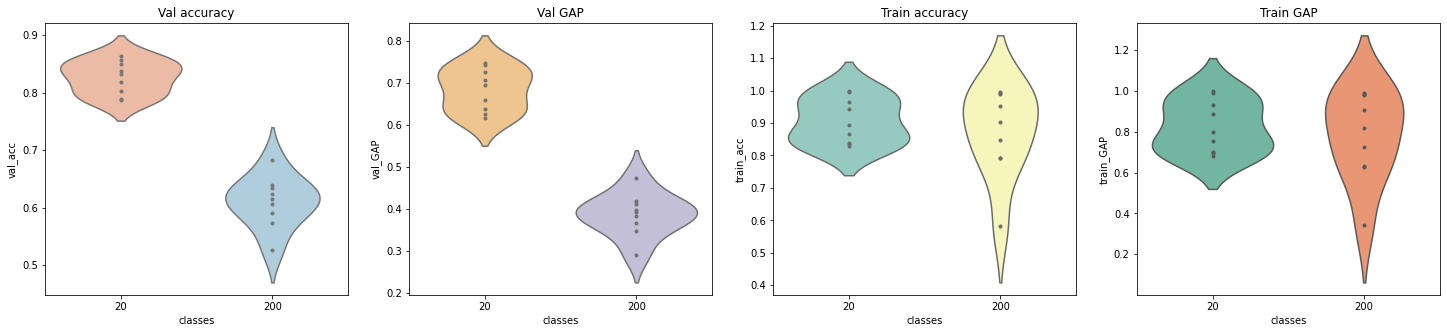

In [65]:
plot_violin(Xception_fine_tuning)

Pretty much the same as all the previous violin plots. What is interesting it the fact that Xception feature extraction and fine tuning do not have so bigger difference as happens with the VGG architecture.

In [66]:
df = Xception_fine_tuning[Xception_fine_tuning['classes']==200][params_fine_tuning].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,freezed_layers,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
5,200,True,126,RMSprop,0.00010,40,0.849,0.724,0.683,0.474
4,200,True,126,RMSprop,0.00010,40,0.791,0.630,0.639,0.419
1,200,False,126,RMSprop,0.00001,40,0.991,0.982,0.634,0.411
2,200,False,126,RMSprop,0.00001,40,0.904,0.818,0.623,0.396
0,200,False,128,RMSprop,0.00001,40,0.953,0.909,0.616,0.392
17,200,False,130,RMSprop,0.00010,40,0.995,0.991,0.607,0.383
16,200,False,130,RMSprop,0.00010,40,0.993,0.986,0.591,0.366
15,200,False,130,RMSprop,0.00001,40,0.792,0.632,0.573,0.346
3,200,True,126,RMSprop,0.00001,40,0.584,0.344,0.527,0.290


As the Xception architecture has more layers, the number of freezed layers is bigger. However the same criteria as before was followed for the number of unfrozen ones.

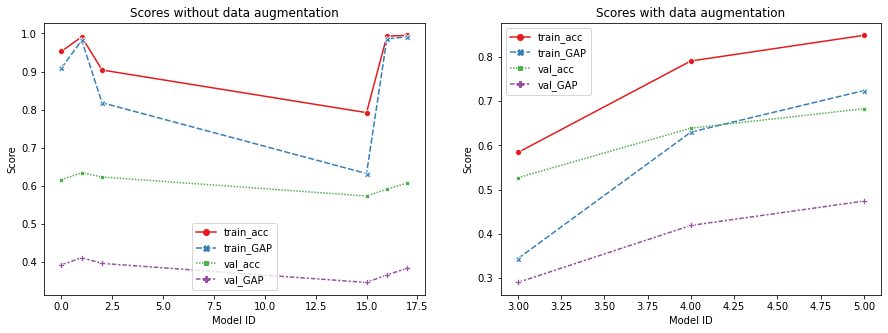

In [67]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

In [68]:
df = Xception_fine_tuning[Xception_fine_tuning['classes']==20][params_fine_tuning].sort_values(by="val_acc",ascending=False)
df

,classes,data_augmentation,freezed_layers,optimizer,learning_rate,epochs,train_acc,train_GAP,val_acc,val_GAP
8,20,False,128,RMSprop,0.00001,40,0.999,0.998,0.863,0.748
7,20,False,126,RMSprop,0.00001,40,0.995,0.990,0.857,0.742
14,20,False,130,RMSprop,0.00001,40,0.942,0.888,0.849,0.727
6,20,False,126,RMSprop,0.00001,40,0.964,0.930,0.838,0.706
13,20,True,126,RMSprop,0.00010,40,0.894,0.800,0.833,0.696
9,20,True,128,RMSprop,0.00001,40,0.866,0.753,0.818,0.659
12,20,True,126,RMSprop,0.00001,40,0.837,0.703,0.803,0.638
11,20,True,128,RMSprop,0.00010,40,0.829,0.684,0.789,0.625
10,20,True,128,RMSprop,0.00001,40,0.834,0.698,0.788,0.616


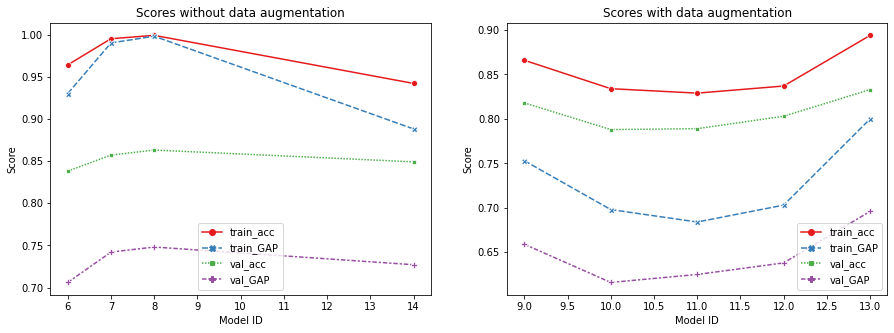

In [69]:
df1 = df[df["data_augmentation"] == False]
df2 = df[df["data_augmentation"] == True]
plot_lines(df1, df2)

Again, the same pattern with data augmentation is repeated, so definitely another kind of approach will be necessary to deal with it.

In [70]:
# Get only the best model with 200 classes based on accuracy
db1 = Xception_fine_tuning[Xception_fine_tuning['classes']==200]
Xception_ft_best_model_200 = db1[db1['val_acc']==db1['val_acc'].max()]
Xception_ft_best_model_200["kind"] = "Xception_fine_tuning"
Xception_ft_best_model_200

,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout,dropout_1,kind
5,200,128,512,True,0.0001,RMSprop,40,126,200,True,0.545,0.849,0.724,1.366,0.683,0.474,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5,NaN,Xception_fine_tuning


In [71]:
# Get only the best model with 20 classes based on accuracy
db2 = Xception_fine_tuning[Xception_fine_tuning['classes']==20]
Xception_ft_best_model_20 = db2[db2['val_acc']==db2['val_acc'].max()]
Xception_ft_best_model_20["kind"] = "Xception_fine_tuning"
Xception_ft_best_model_20

,classes,img_size,batch,data_augmentation,learning_rate,optimizer,epochs,freezed_layers,dense,flatten,train_loss,train_acc,train_GAP,val_loss,val_acc,val_GAP,model,tensorboard,dense_1,dropout,dropout_1,kind
8,20,128,256,False,0.00001,RMSprop,40,128,20,True,0.023,0.999,0.998,0.504,0.863,0.748,/content/drive/MyDrive/4º de Carrera/TFG/Model...,/content/drive/MyDrive/4º de Carrera/TFG/Tenso...,512.0,0.5,NaN,Xception_fine_tuning


# Other annotations


**Note** -- Due to the structure of the registry and the kind of data there are some facts that cannot be easily representend in a graphic way. That is why some data is shown in tables.

One fact that was noted while making the experiments was that adding layers on the top classification block of the model do not imply higher scores, what is more in most cases the accuracy decreased some decimals. These can be observed looking the columns that indicate the kind of layers are full of NaNs.

Other intereseting fact is the time of training for each model. It mostly relies on the power of the GPU, but there are other aspects that
have influence on it. Xception usually need more time for executing the same epochs as VGG and it is directly related to the size of the neural network. Also, many of the models haven't trained for all the specified epochs on the registry because they converge quickly and the early stopping callback had terminated the process. This can be visualized on the TensorBoard with the different learning curves.

Going on with the learning curves sometimes these ones have changed unexpectedly between one experiment and other, just for modifying the value of one hyperparameter. That gives the clue about their high impact on the model. While there are some unstable curves, there are smoother ones. Nevertheless, the most common shape is a **logarithmic** one. At certain epoch, the improvement of the models becomes slower and slower, so early stopping do its job or the model needs even more time that we cannot afford with our resources.

# Ranking

Once the best models are obtained  from each batch of experiments a ranking is going to be made in order to select the final model according to the number of classes.

In [72]:
params = ["kind",  "learning_rate", "optimizer", "val_acc", "val_GAP", "train_acc", "train_GAP", "batch", "img_size", "model" ]
ranking = pd.DataFrame()
ranking = ranking.append(VGG_fe_best_model_200[params])
ranking = ranking.append(VGG_ft_best_model_200[params])
ranking = ranking.append(Xception_fe_best_model_200[params])
ranking = ranking.append(Xception_ft_best_model_200[params])
ranking.sort_values(by='val_acc', ascending=False)

,kind,learning_rate,optimizer,val_acc,val_GAP,train_acc,train_GAP,batch,img_size,model
7,VGG_fine_tuning,0.0001,RMSprop,0.715,0.522,1.000,1.000,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
5,Xception_fine_tuning,0.0001,RMSprop,0.683,0.474,0.849,0.724,512.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
6,VGG_feature_extraction,0.0001,Adam,0.616,0.388,1.000,0.999,512.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
2,Xception_feature_extraction,0.0001,Adam,0.599,0.377,0.968,0.939,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...


In [73]:
ranking.to_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/ranking_200.csv")

As it was expected from the previous section, models trained with the fine tuning technique have better performance. The difference between both archictures is not too big, but here as in every competition every decimals means important advantage against competitors.

In [74]:
best_model_200 = ranking[ranking['val_acc']==ranking['val_acc'].max()]
best_model_200

,kind,learning_rate,optimizer,val_acc,val_GAP,train_acc,train_GAP,batch,img_size,model
7,VGG_fine_tuning,0.0001,RMSprop,0.715,0.522,1.0,1.0,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...


In [75]:
ranking = pd.DataFrame()
ranking = ranking.append(VGG_fe_best_model_20[params])
ranking = ranking.append(VGG_ft_best_model_20[params])
ranking = ranking.append(Xception_fe_best_model_20[params])
ranking = ranking.append(Xception_ft_best_model_20[params])
ranking.sort_values(by='val_acc', ascending=False)

,kind,learning_rate,optimizer,val_acc,val_GAP,train_acc,train_GAP,batch,img_size,model
12,VGG_fine_tuning,0.000001,RMSprop,0.904,0.817,1.000,1.000,512.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
8,Xception_fine_tuning,0.000010,RMSprop,0.863,0.748,0.999,0.998,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
13,Xception_feature_extraction,0.000100,Adam,0.840,0.708,0.999,0.998,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...
14,VGG_feature_extraction,0.000100,Adam,0.832,0.691,0.997,0.993,256.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...


In [76]:
ranking.to_csv("/content/drive/MyDrive/4º de Carrera/TFG/Experiments/ranking_20.csv")

The same happens with model trained only on 20 classes. It seems that VGG is the clear winner of all models.

In [77]:
best_model_20 = ranking[ranking['val_acc']==ranking['val_acc'].max()]
best_model_20

,kind,learning_rate,optimizer,val_acc,val_GAP,train_acc,train_GAP,batch,img_size,model
12,VGG_fine_tuning,0.000001,RMSprop,0.904,0.817,1.0,1.0,512.0,128.0,/content/drive/MyDrive/4º de Carrera/TFG/Model...


In both cases the fine tuning technique is the one with higher score, so we can conclude at this point that these kind of transfer learning has worked better than feature extraction. However, there are other aspects to take into account as for example the time and computational cost since fine tuning is more demanding.

# Evaluation

To carry out the evaluation of the two selected models, first of all the set of test images must be loaded and also some of the dependencies that the models have in order to be compiled and evaluated.

In [78]:
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/test_200.zip'
! unzip -qq '/content/drive/MyDrive/4º de Carrera/TFG/test_20.zip'

In [79]:
def GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

In [80]:
dependencies = {
    'tf': tf,
    'GAP': GAP
}

## Best model - 200 classes

This steps are familiar because they are the same ones as the model building with Keras with the difference that now there are no hyperparameters or layers to declare because everything is stored on the generated checkpoint files from the training process.

In [81]:
path = best_model_200["model"].values[0]
model = load_model(path,custom_objects=dependencies)

In [82]:
LR = best_model_200["learning_rate"].values[0]
optimizer = best_model_200["optimizer"].values[0]
print("Learning Rate: ",LR)
print("Optimizer: ", optimizer)

Learning Rate:  0.0001
Optimizer:  RMSprop


In [83]:
metrics = [GAP, "accuracy"]  #The ones used on the experiments
model.compile(optimizer=RMSprop(learning_rate=LR),  # Same as indicated on the registry
              loss=CategoricalCrossentropy(), 
              metrics=metrics)

In [84]:
BATCH_SIZE = best_model_200["batch"].values[0]
IMG_SIZE = (int(best_model_200["img_size"].values[0]), int(best_model_200["img_size"].values[0]))

test_dir = "..test_200"
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=False,
                                            label_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=seed)

Found 7801 files belonging to 200 classes.


In [85]:
with tf.device('/device:GPU:0'):
  loss, gap, acc = model.evaluate(test_dataset)

print('Test accuracy :', acc)
print('Test GAP :', gap)
print('Test loss: ', loss)

31/31 [==============================] - 104s 1s/step - loss: 1.7415 - GAP: 0.5243 - accuracy: 0.7256
Test accuracy : 0.7205486297607422
Test GAP : 0.5224232077598572
Test loss:  1.7888716459274292


The accuracy of the model on the test set is not the best, but is quite enough to consider it as an acceptable solution to the proposed problem.

In [86]:
def plot_sample_predictions(test_dataset):
  class_names = test_dataset.class_names
  sample = test_dataset.shuffle(9, seed=seed)
  image_batch, label_batch = sample.as_numpy_iterator().next()   #test_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  predictions = [p.argmax() for p in predictions]

  # Plot the predicted labels for certain images
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Predicted class: [{class_names[predictions[i]]}]\n True class: [{class_names[np.argmax(label_batch[i])]}]")
    plt.axis("off")

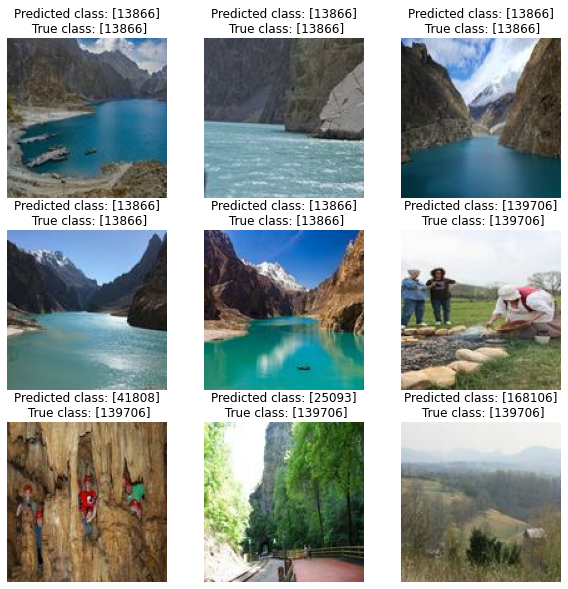

In [87]:
plot_sample_predictions(test_dataset)

As we can see a most of the photos from the random sample are predicted well, but there are others which not. Let's see an example of a misprediction just to understand a little bit more why the model make these mistakes.

In [88]:
def plot_mistaken_class_photos(label, path):
  class_path = f"{path}/{label}/"
  _, _, filenames = next(os.walk(class_path))

  filenames = [os.path.join(class_path,f) for f in filenames] 

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    file = random.choice(filenames) 
    image = mpimg.imread(file)
    plt.imshow(image)
    plt.title(f"Class: [{label}]")
    plt.axis("off")

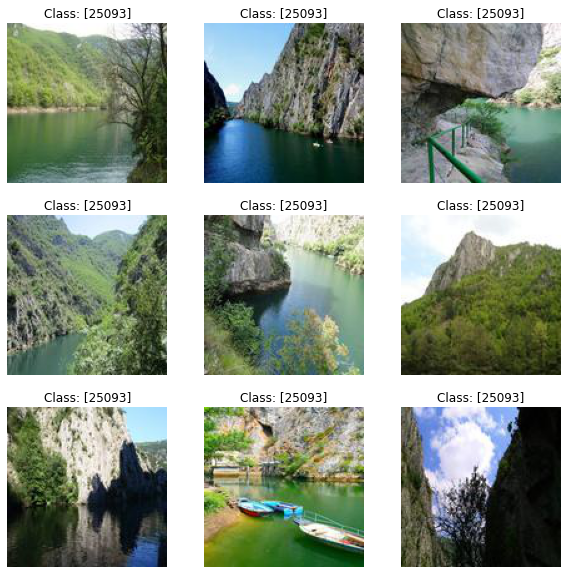

In [89]:
plot_mistaken_class_photos(25093, "..test_200")

The reason why the model is confused in its prediction of the photo belonging to the class 139706 with this one is quite obvious. Trees and green landscapes are very similar, so the features that distinguish both classes must be very few and are easily confused. However, this can be just one reason for this case, but it stills in some way a speculation about what is happening inside the complexity of the neural network.

## Best Model - 20 classes

The same process, but now with the model trained on 20 classes

In [90]:
path = best_model_20["model"].values[0]
model = load_model(path,custom_objects=dependencies)

In [91]:
LR = best_model_20["learning_rate"].values[0]
optimizer = best_model_20["optimizer"].values[0]
print("Learning Rate: ",LR)
print("Optimizer: ", optimizer)

Learning Rate:  1e-06
Optimizer:  RMSprop


In [92]:
metrics = [GAP, "accuracy"]
model.compile(optimizer=Adam(learning_rate=LR), # Check out the optimizer before compiling
              loss=CategoricalCrossentropy(), 
              metrics=metrics)

In [93]:
BATCH_SIZE = best_model_20["batch"].values[0]
IMG_SIZE = (int(best_model_20["img_size"].values[0]), int(best_model_20["img_size"].values[0]))

test_dir = "..test_20"
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=False,
                                            label_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=seed)

Found 1796 files belonging to 20 classes.


In [94]:
with tf.device('/device:GPU:0'):
  loss, gap, acc = model.evaluate(test_dataset)

print('Test accuracy :', acc)
print('Test GAP :', gap)
print('Test loss: ', loss)

4/4 [==============================] - 76s 10s/step - loss: 0.5730 - GAP: 0.8222 - accuracy: 0.8929
Test accuracy : 0.8981069326400757
Test GAP : 0.8351297378540039
Test loss:  0.5434949398040771


The accuracy is lot better than the model with 200 classes. What is more, it cam be considered a very good classifier. However, there still a wide margin for improvement.

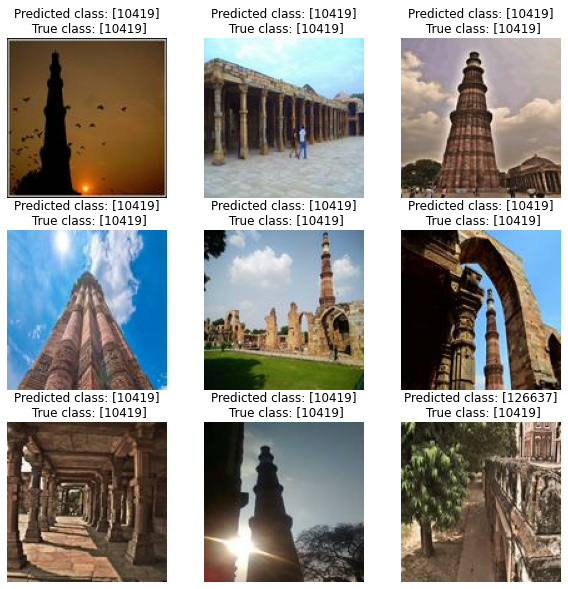

In [95]:
plot_sample_predictions(test_dataset)

Almost all the images from the random sample are predicted correctly, except one. It is very curious since all the images belongs to the same class, but none is equal to the other. Again, the intra-class variance is one of the toughest challenges of this dataset and apparently this model is sorting well. 

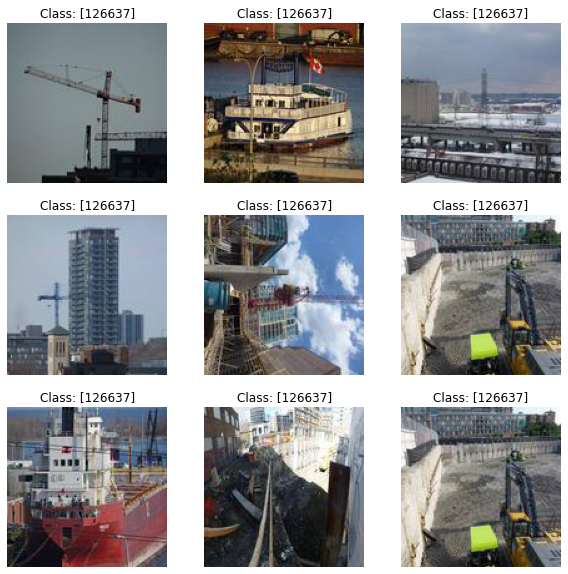

In [96]:
plot_mistaken_class_photos(126637, "..test_20")

Contrary to what happened before, now it seems more difficult to find any reason for the model to have confused classes. At first glance any image in the sample is similar, which is very puzzling as there is surely something hidden that the network is picking up and we are not able to see without pre-processing the images.

# Conclusions

There are several conclusions to be drawn from this analysis of results:


*   Data augmentation affects on the gap between train and validation scores, but does not imply an improvement.
*   Fine tuning has pushed up the metrics some decimals against feature extraction
*   Xception is outperformed by VGG in both cases
*   The intra class variance makes the models struggle in their predictions and it is the main reason of the mispredictions.
*   Scaling down the classes to train the models has result in a great success since the score have improved significantly.

